# Load libraries

In [1]:
import time
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime, timezone
from dateutil import parser

# View games playing today
This will also help select which game you want to select

In [2]:
# Examples ref: https://github.com/swar/nba_api/blob/master/docs/examples/LiveData.ipynb
# API ref: https://developer.sportradar.com/docs/read/basketball/NBA_v7#play-by-play
from nba_api.live.nba.endpoints import scoreboard, playbyplay

# Print game date and teams to get gameID
f = "{gameId}: {awayTeam} vs. {homeTeam} @ {gameTimeLTZ}" 

board = scoreboard.ScoreBoard()
games = board.games.get_dict()
print("ScoreBoardDate: " + board.score_board_date)

for game in games:
    gameTimeLTZ = parser.parse(game["gameTimeUTC"]).replace(tzinfo=timezone.utc).astimezone(tz=None)
    print(f.format(gameId=game['gameId'], awayTeam=game['awayTeam']['teamName'], homeTeam=game['homeTeam']['teamName'], gameTimeLTZ=gameTimeLTZ))

ScoreBoardDate: 2023-03-04
0022200957: Pistons vs. Cavaliers @ 2023-03-04 19:30:00-05:00
0022200958: Hawks vs. Heat @ 2023-03-04 20:00:00-05:00
0022200959: Rockets vs. Spurs @ 2023-03-04 20:00:00-05:00
0022200960: 76ers vs. Bucks @ 2023-03-04 20:30:00-05:00
0022200956: Raptors vs. Wizards @ 2023-03-04 17:00:00-05:00
0022200961: Timberwolves vs. Kings @ 2023-03-04 22:00:00-05:00


# Create functions to update data with play by play API

In [3]:
# Change gid according to which game you want to follow from above, default to latest game
def get_api(gid = 0):
    board = scoreboard.ScoreBoard()
    games = board.games.get_dict()
    pbp = playbyplay.PlayByPlay(games[gid]['gameId'])
    actions = pbp.get_dict()['game']['actions']
    return actions, games, gid

In [4]:
def refresh_data(actions, games, gid = 0):
    df = pd.DataFrame({'elapsed': [0],
                       'homescore': [0],
                       'awayscore': [0]})
    elapsed = 0
    m = 12
    s = 0
    period = 1
    homescore = 0
    awayscore = 0
    skipped = 0
    
    # Define consistent variables to avoid unecessary computing
    home = games[gid]['homeTeam']['teamCity'] + ' ' + games[gid]['homeTeam']['teamName']
    away = games[gid]['awayTeam']['teamCity'] + ' ' + games[gid]['awayTeam']['teamName']
    plt.xlabel("Seconds Elapsed")
    plt.ylabel("Points")
    
    # Add all current point and time events to df
    for action in actions:
        period = action['period']
        clock = action['clock']
        s = int(clock.split('M', 1)[1][0:2])
        m = int(clock.split('M', 1)[0][2:4])
        sstring = clock.split('M', 1)[1][0:2]
        mstring = clock.split('M', 1)[0][2:4]
        
        # Some actions are not made baskets, we only want made baskets
        if 'pt' in action['actionType']:
            if action['shotResult'] == 'Made':
                homescore = int(action['scoreHome'])
                awayscore = int(action['scoreAway'])
                elapsed = (period*720) - ((m*60) + s)
                t = time.strftime("%H:%M:%S", time.gmtime(elapsed))
                df.loc[len(df.index)] = [elapsed, homescore, awayscore]
    
    # Visualize point progression for each team and update with only one plot in display window
    display.clear_output(wait=True)
    plt.title(f'{home} vs. {away}\n{homescore} - {awayscore}\n{mstring}:{sstring} ({period} qtr)')
    plt.plot(df.elapsed, df.homescore, label = home)
    plt.plot(df.elapsed, df.awayscore, label = away)
    plt.legend()
    display.display(plt.show())
    
    return df, home, away, homescore, awayscore

# Auto update until game has ended

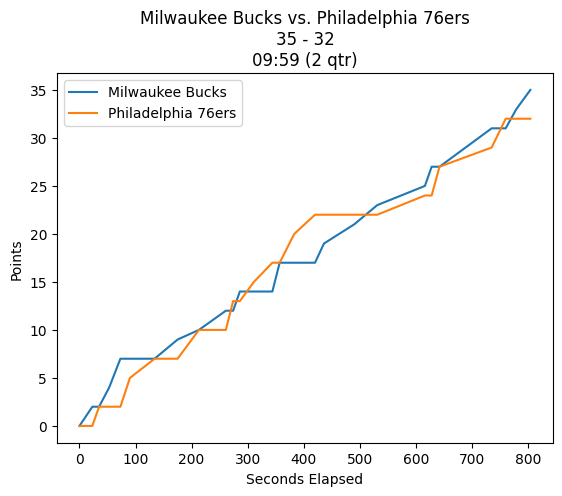

None

In [ ]:
from IPython import display

# Refresh data and view every 5 seconds until game is over
while True:
    actions, games, gid = get_api(gid = 3) # change gid cooresponding to game from
    df, home, away, homescore, awayscore = refresh_data(actions, games, gid)
    time.sleep(5) # Change wait time (seconds) depending on preference
    if actions[-1]['actionType'] == 'game': # End with this unique keyword in API
        break

# Print summary at the end
print(f'Game Over\n{home} {homescore}-{awayscore} {away}')